In [1]:
import sys
sys.path.insert(0, './pyLDLE2/')

In [2]:
import numpy as np
from pyLDLE2 import util_, visualize_, datasets
from scipy.sparse import coo_matrix
from scipy import optimize
from scipy.special import erf, erfinv
from matplotlib import pyplot as plt
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
from scipy.stats import chi2

from tqdm.notebook import tqdm
from sklearn.decomposition import PCA

matplotlib.get_backend() =  module://matplotlib_inline.backend_inline


In [3]:
vis = visualize_.Visualize()

In [4]:
X, labelsMat, ddX = datasets.Datasets().hemiflower_uniform(n=2000, noise=0.05)

X.shape =  (1162, 4)


./pyLDLE2/pyLDLE2/datasets.py:196: RuntimeWarning: invalid value encountered in sqrt
  zv = np.sqrt(1 - xv*xv - yv*yv)


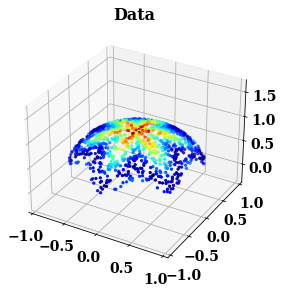

In [5]:
vis.data(X[:,:3], ddX)

In [6]:
k_nn = 128
neigh_dist, neigh_ind = util_.nearest_neighbors(X, k_nn, metric='euclidean')

In [7]:
h_cand = np.sqrt(2)*neigh_dist[:,-1]/np.sqrt(chi2.ppf(0.99, df=2))
print(np.min(h_cand), np.median(h_cand), np.max(h_cand))
h = np.min(h_cand)

0.1294708316025175 0.15612474753742248 0.3055977971018383


In [8]:
neigh_dist = np.zeros(neigh_dist.shape)
for i in tqdm(range(neigh_dist.shape[0])):
    X_i_nbrs = X[neigh_ind[i,:].tolist(),:]
    pca = PCA(n_components=2)
    y = pca.fit_transform(X_i_nbrs)
    X_rec = pca.inverse_transform(y)
    temp = X_rec - X_rec[0,:][None,:]
    neigh_dist[i,:] = np.linalg.norm(temp, axis=1)

  0%|          | 0/1162 [00:00<?, ?it/s]

In [9]:
K = np.exp(-neigh_dist**2/h**2)

In [10]:
n = X.shape[0]
source_ind = np.repeat(np.arange(n),neigh_ind.shape[1])
K = coo_matrix((K.flatten(),(source_ind, neigh_ind.flatten())),shape=(n,n))
ones_K_like = coo_matrix((np.ones(neigh_dist.shape).flatten(),(source_ind, neigh_ind.flatten())),shape=(n,n))

# symmetrize
K = K + K.T
ones_K_like = ones_K_like + ones_K_like.T
K.data /= ones_K_like.data

In [11]:
mu_hN_norm = np.zeros(X.shape[0])
for i in tqdm(range(X.shape[0])):
    X_i_nbrs = X[neigh_ind[i,:].tolist(),:]
    pca = PCA(n_components=2)
    y = pca.fit_transform(X_i_nbrs)
    X_rec = pca.inverse_transform(y)
    temp = X_rec - X_rec[0,:][None,:]
    mu_hN_norm[i] = np.linalg.norm(K.getrow(i)[0,neigh_ind[i,:]].dot(temp))

  0%|          | 0/1162 [00:00<?, ?it/s]

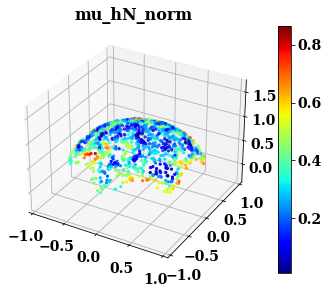

In [12]:
vis.data(X[:,:3], mu_hN_norm, title='mu_hN_norm', colorbar=True)

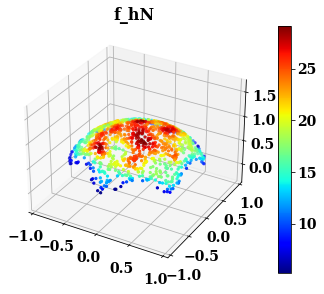

In [13]:
vis.data(X[:,:3], np.array(K.sum(axis=1)).flatten(), title='f_hN', colorbar=True)

In [14]:
c_num = h*np.array(K.sum(axis=1)).flatten()/np.sqrt(np.pi)
c_denom = mu_hN_norm
c = c_num/(c_denom+1e-20)

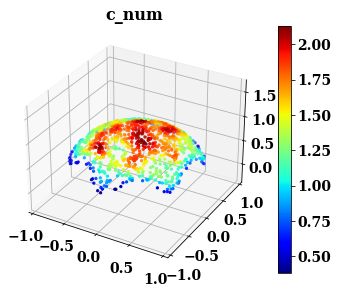

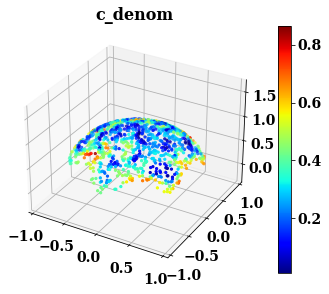

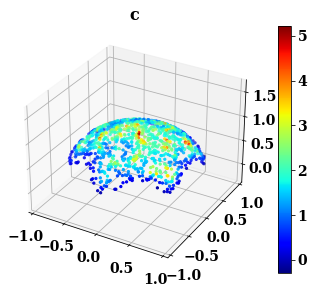

In [15]:
vis.data(X[:,:3], c_num, title='c_num', colorbar=True)
vis.data(X[:,:3], c_denom, title='c_denom', colorbar=True)
vis.data(X[:,:3], np.log(c), title='c', colorbar=True)

In [16]:
def F(x):
    return c_denom*(1+erf(x/h))*np.exp(x**2/h**2)-c_num

def F_prime(x):
    return (c_denom/h)*(2/np.sqrt(np.pi) + 2*(1+erf(x/h))*np.exp(x**2/h**2)*x/h)

In [17]:
bx_init = h*np.sqrt(np.maximum(0, -np.log(2*c_denom+1e-30)+np.log(c_num+1e-30)))

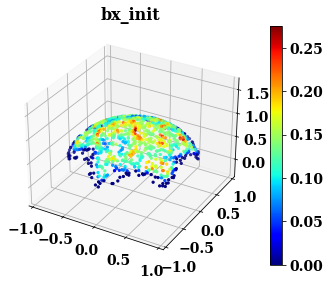

In [18]:
vis.data(X[:,:3], bx_init, title='bx_init', colorbar=True)

In [19]:
bx = optimize.newton(F, bx_init, F_prime, maxiter=10000)

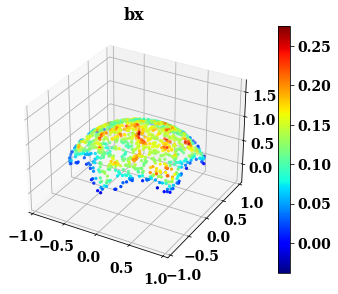

In [20]:
vis.data(X[:,:3], bx, title='bx', colorbar=True)

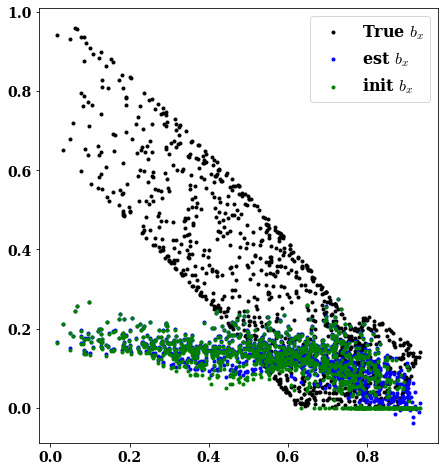

In [21]:
plt.figure(figsize=(8,8))
plt.scatter(np.linalg.norm(X[:,:2], axis=1), ddX, color='k', label='True $b_x$')
plt.scatter(np.linalg.norm(X[:,:2], axis=1), bx, color='b', label='est $b_x$')
plt.scatter(np.linalg.norm(X[:,:2], axis=1), bx_init, color='g', label='init $b_x$')
plt.axis('image')
plt.legend()

In [22]:
np.linalg.norm(bx - ddX) / np.linalg.norm(ddX)

0.7164780196535507